In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-24 14:54:39.977526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 14:54:40.753299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-24 14:54:41.439525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 14:54:41.482162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [2]:
train_ds, val_ds, test_ds = load_dataset()

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


2024-04-24 14:54:42.277229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 14:54:42.277459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 14:54:42.277605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель InceptionV3 без верхних слоев:

In [3]:
base_model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [4]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [5]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,872,392 (87.25 MB)

 Trainable params: 1,069,608 (4.08 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Начнем обучение модели с замороженными нижними слоями:

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [8]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/inception_v3.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [9]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713945291.176049   98475 service.cc:145] XLA service 0x7d8d7c5561a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713945291.176080   98475 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 14:54:51.344694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 14:54:52.691212: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/433 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.0000e+00 - loss: 4.0172   

I0000 00:00:1713945301.703422   98475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.1974 - loss: 3.1257 - val_accuracy: 0.4932 - val_loss: 1.8311
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.4861 - loss: 1.8561 - val_accuracy: 0.5702 - val_loss: 1.5413
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.5484 - loss: 1.5779 - val_accuracy: 0.5972 - val_loss: 1.3999
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.5957 - loss: 1.4085 - val_accuracy: 0.6138 - val_loss: 1.3265
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.6291 - loss: 1.2940 - val_accuracy: 0.6307 - val_loss: 1.2676
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.6513 - loss: 1.2026 - val_accuracy: 0.6330 - val_loss: 1.2409
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.6719 - loss: 1.1281 - val_accuracy: 0.6398 - val_loss: 1.2065
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.6860 - loss: 1.0662 - val_accura

Так как число параметров в нижних слоях огромно (более 21 миллиона), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [14]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6883 - loss: 1.0983


In [15]:
results

[1.1245216131210327, 0.6774193644523621]

Посомтрим несколько предсказаний:

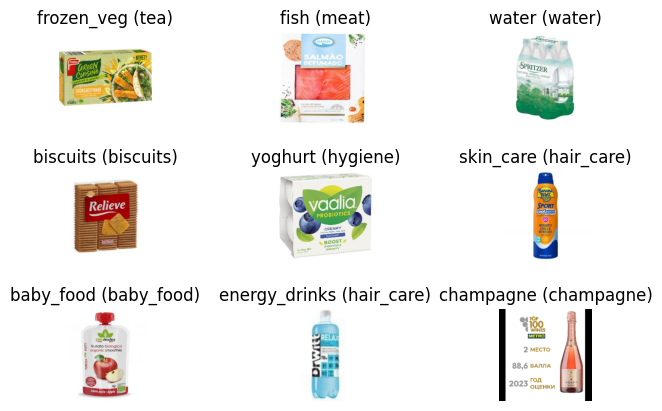

In [16]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


2024-04-24 15:10:59.588187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


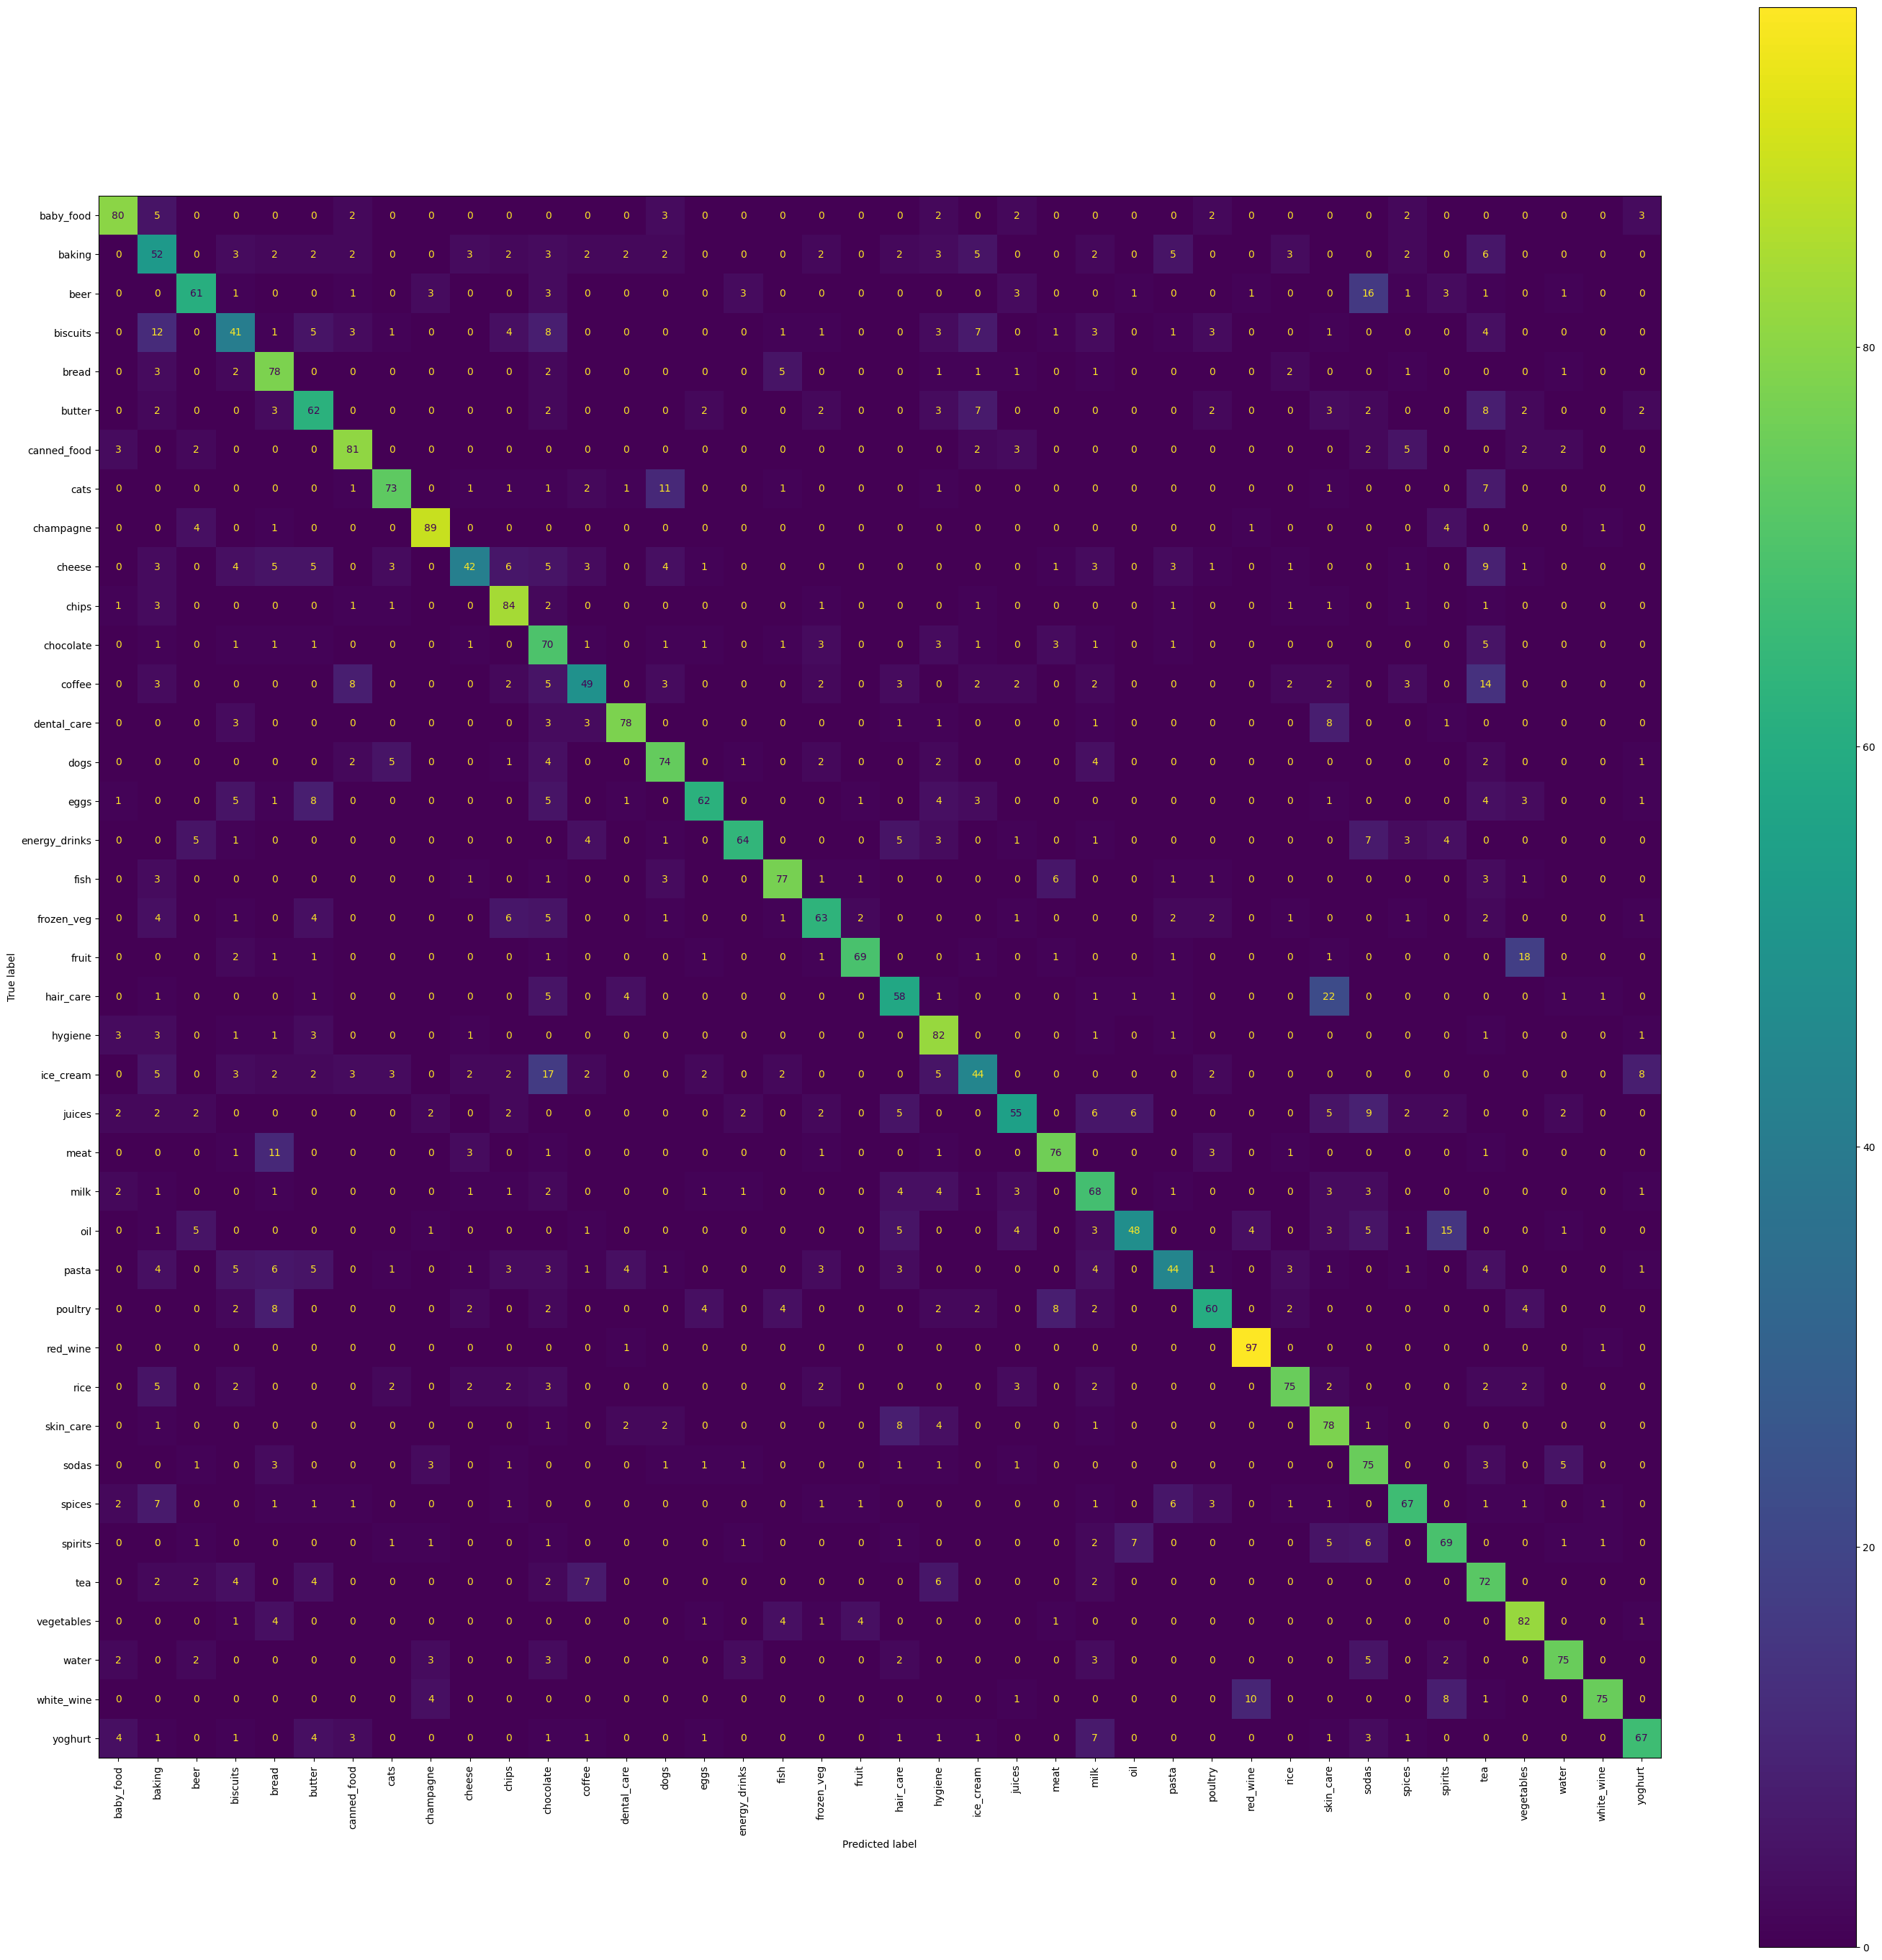

In [17]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [19]:
model.save('ready_models/inception_v3.keras')

In [ ]:
tf.k

In [17]:
import json

with open('models_histories/inception_v3.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

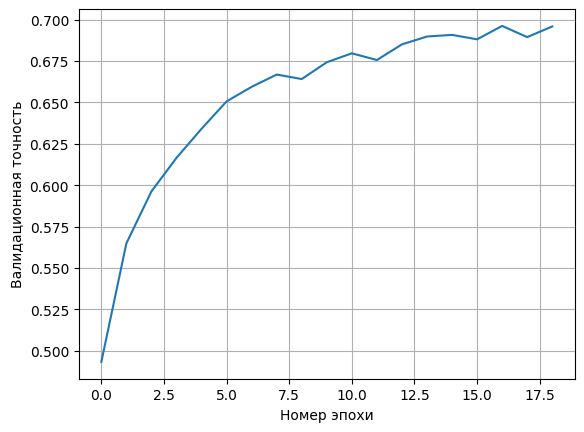

In [18]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')